<a href="https://colab.research.google.com/github/Lykozy/DQLab_training/blob/main/TfLn_Result_Metal_1_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pada notebook ini akan dibuat model RNN LSTM yang akan digunakan dalam penerapan transfer learning untuk memprediksi (forecasting) harga tembaga, model bernama result_metal_1. Model akan dilatih dengan data historis Nickel/Nikel. Penerapan Transfer Learning berada di notebook yang berbeda.

# Pembuatan Model yang akan digunakan dalam penerapan Transfer Learning

## Instal yang diperlukan

In [ ]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

In [ ]:
df = pandas.read_csv('/content/drive/MyDrive/transfer_learning_metal_dataset/Data Historis Nikel Berjangka.csv')

## EDA

In [ ]:
df

,date,close,open,high,low,volume
0,2019-10-1,17.220,17.250,17.325,17.195,239750
1,2019-10-2,17.485,17.525,17.505,17.485,187440
2,2019-10-3,17.625,17.630,17.630,17.610,117020
3,2019-10-4,17.790,17.825,17.790,17.750,82760
4,2019-10-7,17.725,17.800,17.800,17.750,135320
...,...,...,...,...,...,...
503,2021-9-27,18.946,18.900,18.910,18.870,15600
504,2021-9-28,18.564,18.610,18.585,18.600,17460
505,2021-9-29,18.342,18.600,18.555,18.555,21270
506,2021-9-30,17.936,18.170,18.100,18.100,19540


In [ ]:
print(df.shape)

(508, 6)


In [ ]:
main_df = df.reset_index(drop = True)

In [ ]:
print('Number of missing values : ' + str(main_df.isna().sum().sum()))

Number of missing values : 0


In [ ]:
main_df = main_df.drop(['date'], axis = 1)

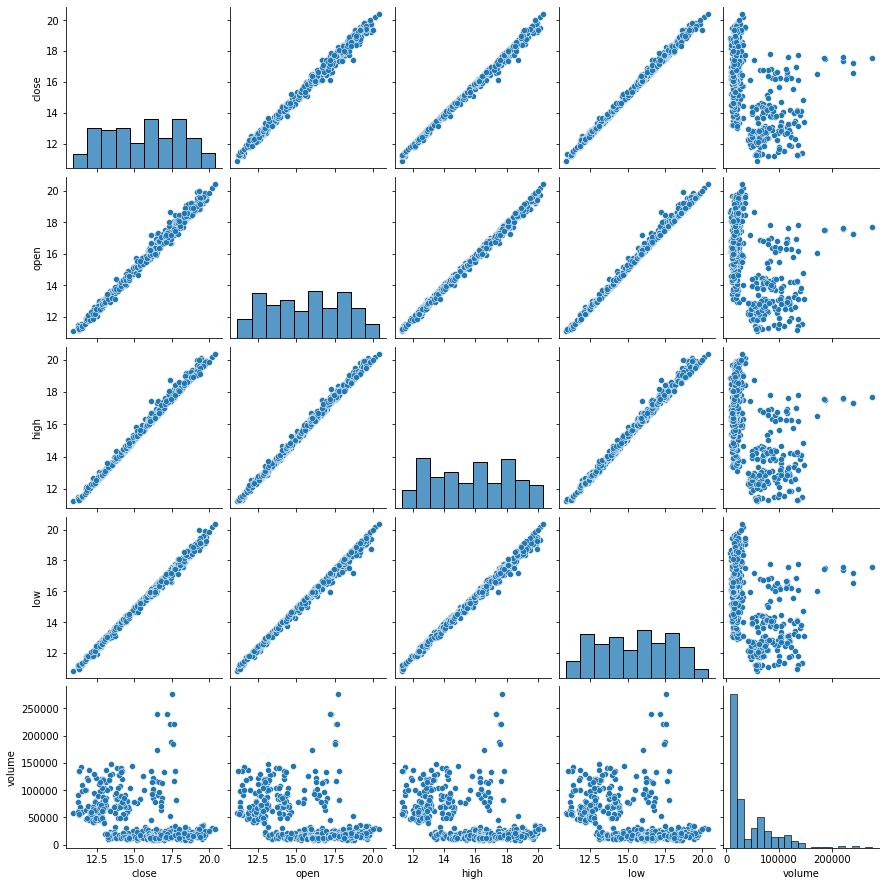

In [ ]:
seaborn.pairplot(main_df)

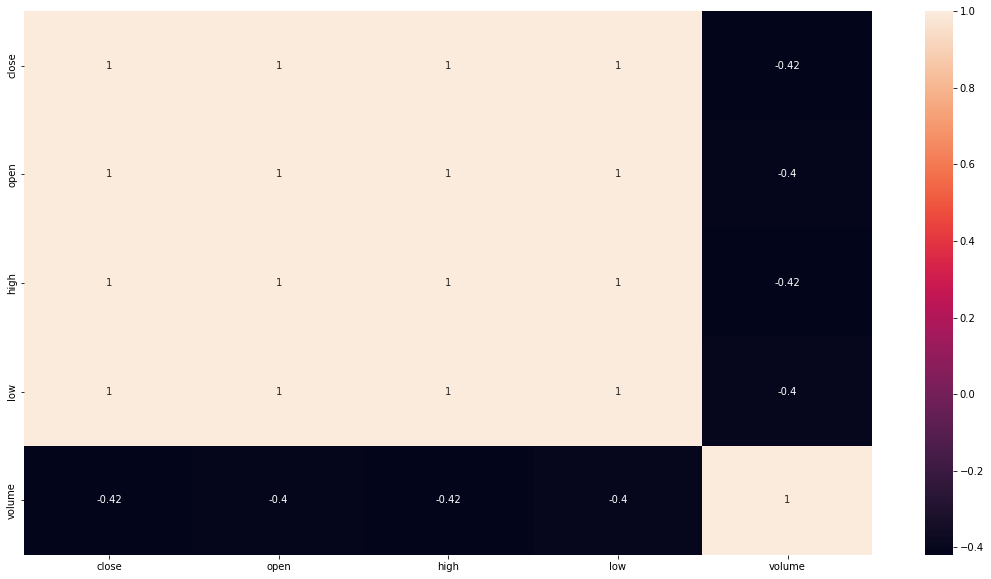

In [ ]:
cor_mat = main_df.corr ()
fig = plt.figure(figsize = (19,10))
seaborn.heatmap(cor_mat, annot = True)
plt.show ()

In [ ]:
print (cor_mat['close'].sort_values(ascending = False), '\n')

close     1.000000
low       0.997962
high      0.997604
open      0.995332
volume   -0.415522
Name: close, dtype: float64 



In [ ]:
column_position = ['open', 'close', 'low', 'high', 'volume']

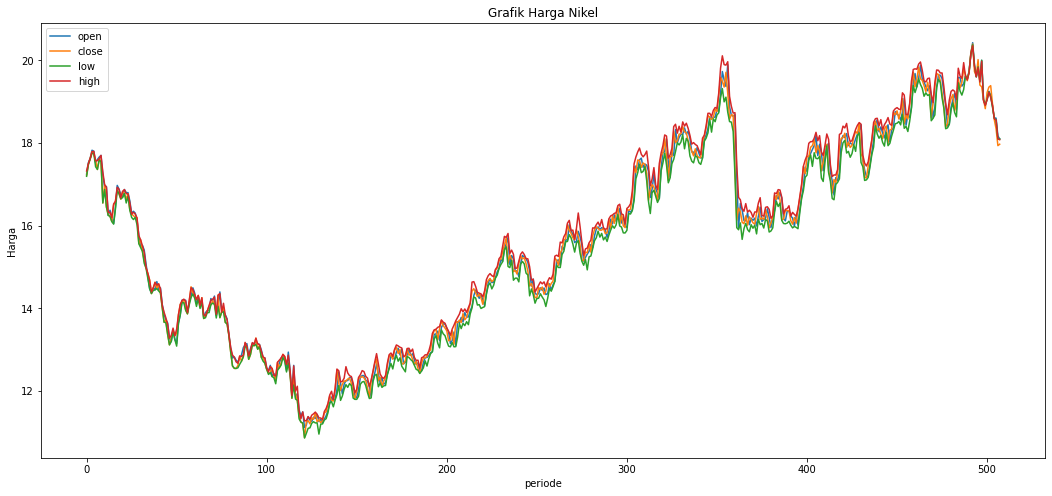

In [ ]:
plt.figure(figsize = (18, 8))
plt.plot(main_df['open'])
plt.plot(main_df['close'])
plt.plot(main_df['low'])
plt.plot(main_df['high'])
plt.legend(['open', 'close','low','high'])
plt.xlabel('periode')
plt.ylabel('Harga')
plt.title('Grafik Harga Nikel')
plt.savefig('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/Model_metal_1_nikel.png')
plt.show()

*** Berhubung open, close, low, high memiliki nilai yang hampir sama, maka hanya 1 yang akan digunakan untuk memberi makan model yaitu close. ***

In [ ]:
info = [[col, main_df[col].count(), main_df[col].max(), main_df[col].min()] for col in main_df.columns]
print(tabulate(info, headers = ['Feature', 'Count', 'Maximum', 'Minimum'], tablefmt= 'orgtbl'))

| Feature   |   Count |    Maximum |   Minimum |
|-----------+---------+------------+-----------|
| close     |     508 |     20.392 |    10.88  |
| open      |     508 |     20.425 |    11.125 |
| high      |     508 |     20.35  |    11.28  |
| low       |     508 |     20.375 |    10.868 |
| volume    |     508 | 276580     |  7720     |


## Membuat Dataset

In [ ]:
X = np.array(main_df.drop(['close', 'low', 'high'], axis = 1))
y = np.array(main_df['close'])

In [ ]:
print(X.shape)
print(y.shape)

(508, 2)
(508,)


## Menskalakan data dengan MinMaxScaler

In [ ]:
print(X[:3])

[[1.7250e+01 2.3975e+05]
 [1.7525e+01 1.8744e+05]
 [1.7630e+01 1.1702e+05]]


In [ ]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
print(X[:3])

[[0.65860215 0.86301421]
 [0.68817204 0.66845198]
 [0.69946237 0.40653128]]


In [ ]:
print(y.min())
print(y.max())

10.88
20.392


In [ ]:
temp = MinMaxScaler().fit_transform(np.reshape(y, (len(y),1)))
y = temp.reshape(-1)

In [ ]:
print(y.min())
print(y.max())

0.0
1.0


In [ ]:
print(X.min())
print(X.max())

0.0
1.0000000000000002


## Membuat array numpy berbasis deret waktu

In [ ]:
length = 120                    
X_res = []
y_res = []

In [ ]:
for i in range(length,len(X)) :
    X_res.append(X[i-length:i])      
    y_res.append(y[i])           

X_res = np.array(X_res)
y_res = np.array(y_res)

In [ ]:
print(X_res.shape)
print(y_res.shape)

(388, 120, 2)
(388,)


In [ ]:
X_res

array([[[0.65860215, 0.86301421],
        [0.68817204, 0.66845198],
        [0.69946237, 0.40653128],
        ...,
        [0.08763441, 0.34129287],
        [0.04569892, 0.50260359],
        [0.02956989, 0.47653054]],

       [[0.68817204, 0.66845198],
        [0.69946237, 0.40653128],
        [0.72043011, 0.27910437],
        ...,
        [0.04569892, 0.50260359],
        [0.02956989, 0.47653054],
        [0.04032258, 0.31012423]],

       [[0.69946237, 0.40653128],
        [0.72043011, 0.27910437],
        [0.71774194, 0.47459644],
        ...,
        [0.02956989, 0.47653054],
        [0.04032258, 0.31012423],
        [0.        , 0.18693744]],

       ...,

       [[0.61021505, 0.01829949],
        [0.59602151, 0.0188574 ],
        [0.54247312, 0.0144313 ],
        ...,
        [0.86290323, 0.02670535],
        [0.83602151, 0.02930893],
        [0.80483871, 0.03622703]],

       [[0.59602151, 0.0188574 ],
        [0.54247312, 0.0144313 ],
        [0.53688172, 0.01182772],
        .

## Train test split

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X_res, y_res, train_size = 0.8, test_size = 0.2, random_state = 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(310, 120, 2)
(310,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(78, 120, 2)
(78,)


## Pembuatan Model

Recurrent Neural Network
Model RNN memiliki memori, yang dapat membantu dalam mempertahankan data masa lalu sehingga prediksi dibuat atas dasar tersebut.

Long Short Term Memory
Model RNN sederhana memiliki memori jangka pendek dan tidak dapat mempertahankan dependensi yang terjadi jauh sebelum keadaan saat ini. Jadi LSTM (Long Short Term Memory) digunakan untuk mempertahankan dependensi tersebut.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
def lstm_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Bidirectional(LSTM(hiddenx, activation = 'tanh', return_sequences = True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [ ]:
def rnn (hidden1, hidden2, hidden3) :
    
    model = Sequential()
    
    # Input Block
    model.add(Input((length, 2,)))
    
    # LSTM Block
    model.add(lstm_layer(hidden1))
    model.add(lstm_layer(hidden2))
    model.add(Bidirectional(LSTM(hidden3, activation = 'tanh', return_sequences = False)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Output Block
    model.add(Dense(1, activation = 'linear'))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='accuracy')
    return model

In [ ]:
model = rnn(64, 32, 16)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 120, 128)          34816     
                                                                 
 sequential_2 (Sequential)   (None, 120, 64)           41472     
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
# ModelChekpoint digunakan untuk menyimpan progres training dari suatu model yang nantinya dapat dilanjutkan lagi, baik dengan notebook
# yang berbeda maupun dengan dataset yang berbeda tetapi masih memiliki struktur yang sama dengan data yang digunakan pada model awal

checkp = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1.h5', save_best_only = False, verbose = 1), 
          tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1.log', separator=",", append=False)]

## Training Model

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    epochs = 200, 
    batch_size = 32, 
    validation_data = (X_test, y_test), 
    callbacks = [checkp])

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 1.1855 - accuracy: 0.0032
Epoch 1: saving model to /content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1.h5
10/10 [==============================] - 24s 776ms/step - loss: 1.1855 - accuracy: 0.0032 - val_loss: 0.3273 - val_accuracy: 0.0000e+00
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.7888 - accuracy: 0.0065
Epoch 2: saving model to /content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1.h5
10/10 [==============================] - 4s 415ms/step - loss: 0.7888 - accuracy: 0.0065 - val_loss: 0.2762 - val_accuracy: 0.0000e+00
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.0032
Epoch 3: saving model to /content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1.h5
10/10 [==============================] - 4s 405ms/step - loss: 0.6901 - accuracy: 0.0032 - val_loss: 0.2349 - val_accuracy: 0.0000e+00
Epoch 

In [ ]:
history.history??

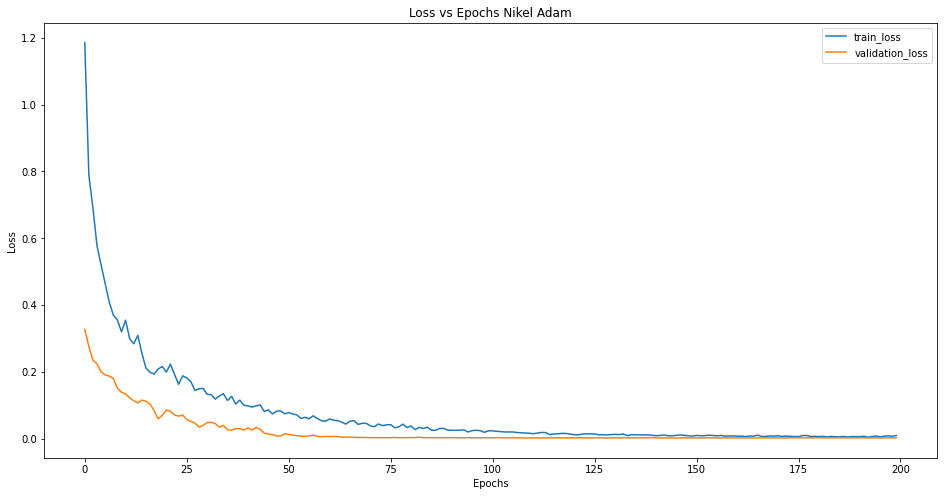

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs Nikel Adam')
plt.savefig('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1_loss.png')
plt.show()

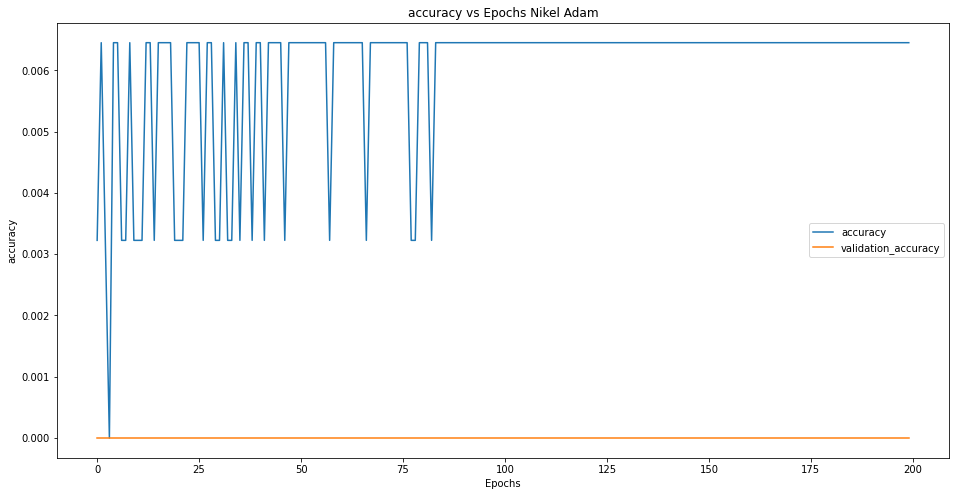

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'validation_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs Epochs Nikel Adam')
plt.savefig('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1_acc.png')
plt.show()

## Prediksi

In [ ]:
model_pred = load_model('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1.h5')

In [ ]:
pred = model_pred.predict(X_test)

In [ ]:
print(pred.shape)

(78, 1)


## Plot the Prediction and Test value

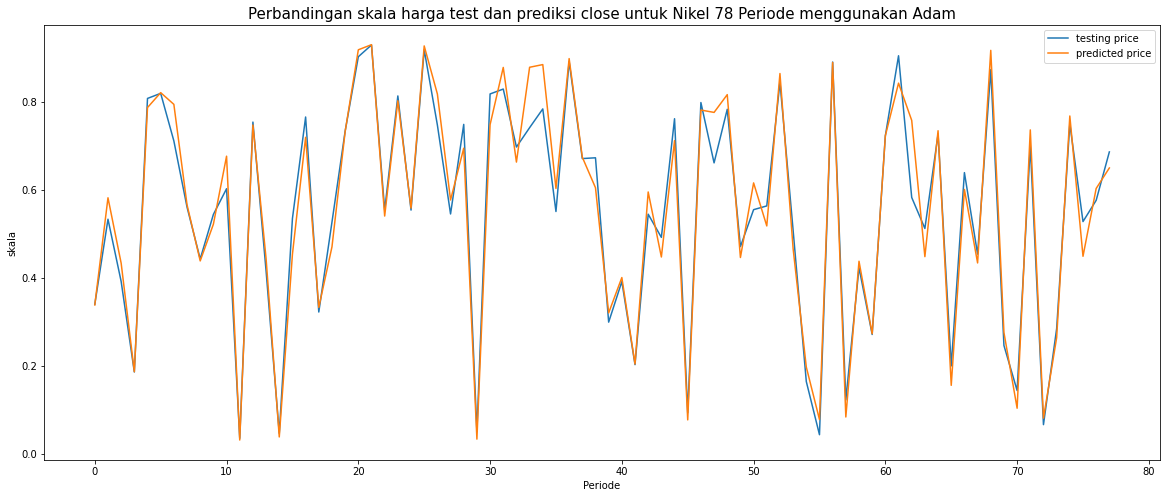

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(y_test)
plt.plot(pred)
plt.xlabel('Periode')
plt.ylabel('skala')
plt.legend(['testing price','predicted price'])
plt.title('Perbandingan skala harga test dan prediksi close untuk Nikel 78 Periode menggunakan Adam', fontsize = 15)
plt.savefig('/content/drive/MyDrive/TransferLearning/LSTM/Adam/Model_1/result_metal_1_comparison_testingVSpredic_78_periode.png')

## Performance Metrics

In [ ]:
print('r2 score : ' + str(r2_score(y_test, pred)))
print('Mean Squared Error (MSE) : ' + str(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error (RMSE) : ' + str(mean_squared_error(y_test, pred, squared=False)))
print('Mean Absolut Error (MAE) : ' + str(mean_absolute_error(y_test, pred)))
print('Mean Absolut Percentage Error (MAPE) : ' + str(mean_absolute_percentage_error(y_test, pred)))

r2 score : 0.9635359483361952
Mean Squared Error (MSE) : 0.0022814613103771014
Root Mean Squared Error (RMSE) : 0.04776464498326248
Mean Absolut Error (MAE) : 0.034982363769555165
Mean Absolut Percentage Error (MAPE) : 0.08958410082616927
